In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline 

# Đọc dữ liệu từ dataset

In [3]:
# Đọc dữ liệu từ file csv và những kí tự ASCII không phù hợp trong dataset
df = pd.read_csv('Mobiles Dataset (2025).csv', encoding='unicode_escape')

In [4]:
# Hiển thị 5 dòng đầu tiên của dataset
print("First 5 rows of the dataset:")
print(df.head())

First 5 rows of the dataset:
  Company Name            Model Name Mobile Weight  RAM Front Camera  \
0        Apple       iPhone 16 128GB          174g  6GB         12MP   
1        Apple       iPhone 16 256GB          174g  6GB         12MP   
2        Apple       iPhone 16 512GB          174g  6GB         12MP   
3        Apple  iPhone 16 Plus 128GB          203g  6GB         12MP   
4        Apple  iPhone 16 Plus 256GB          203g  6GB         12MP   

  Back Camera   Processor Battery Capacity Screen Size  \
0        48MP  A17 Bionic         3,600mAh  6.1 inches   
1        48MP  A17 Bionic         3,600mAh  6.1 inches   
2        48MP  A17 Bionic         3,600mAh  6.1 inches   
3        48MP  A17 Bionic         4,200mAh  6.7 inches   
4        48MP  A17 Bionic         4,200mAh  6.7 inches   

  Launched Price (Pakistan) Launched Price (India) Launched Price (China)  \
0               PKR 224,999             INR 79,999              CNY 5,799   
1               PKR 234,999        

In [5]:
# Hiển thị thông tin chung của dataset (số dòng, cột, kiểu dữ liệu, missing values,...)
print("\nDataset Information:")
print(df.info())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Company Name               930 non-null    object
 1   Model Name                 930 non-null    object
 2   Mobile Weight              930 non-null    object
 3   RAM                        930 non-null    object
 4   Front Camera               930 non-null    object
 5   Back Camera                930 non-null    object
 6   Processor                  930 non-null    object
 7   Battery Capacity           930 non-null    object
 8   Screen Size                930 non-null    object
 9   Launched Price (Pakistan)  930 non-null    object
 10  Launched Price (India)     930 non-null    object
 11  Launched Price (China)     930 non-null    object
 12  Launched Price (USA)       930 non-null    object
 13  Launched Price (Dubai)     930 non-null    

In [6]:
# Hiển thị bảng thống kê mô tả cho các cột số
print("\nDescriptive statistics of numerical columns:")
print(df.describe())


Descriptive statistics of numerical columns:
       Launched Year
count     930.000000
mean     2022.193548
std         1.862080
min      2014.000000
25%      2021.000000
50%      2023.000000
75%      2024.000000
max      2025.000000


# Khám phá dữ liệu (EDA) bằng đồ thị

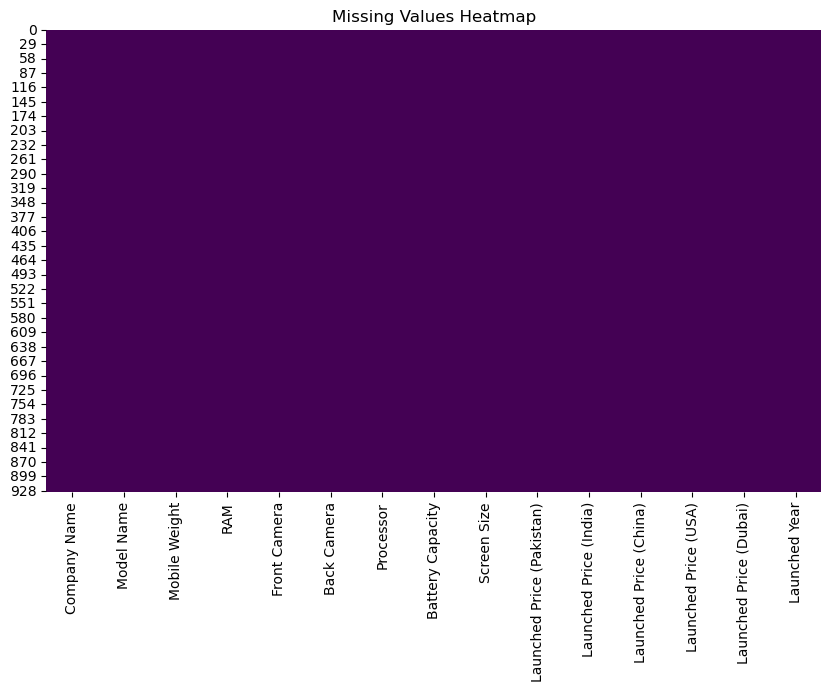

In [7]:
# Biểu đồ heatmap cho các giá trị thiếu (Missing Values Heatmap)
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

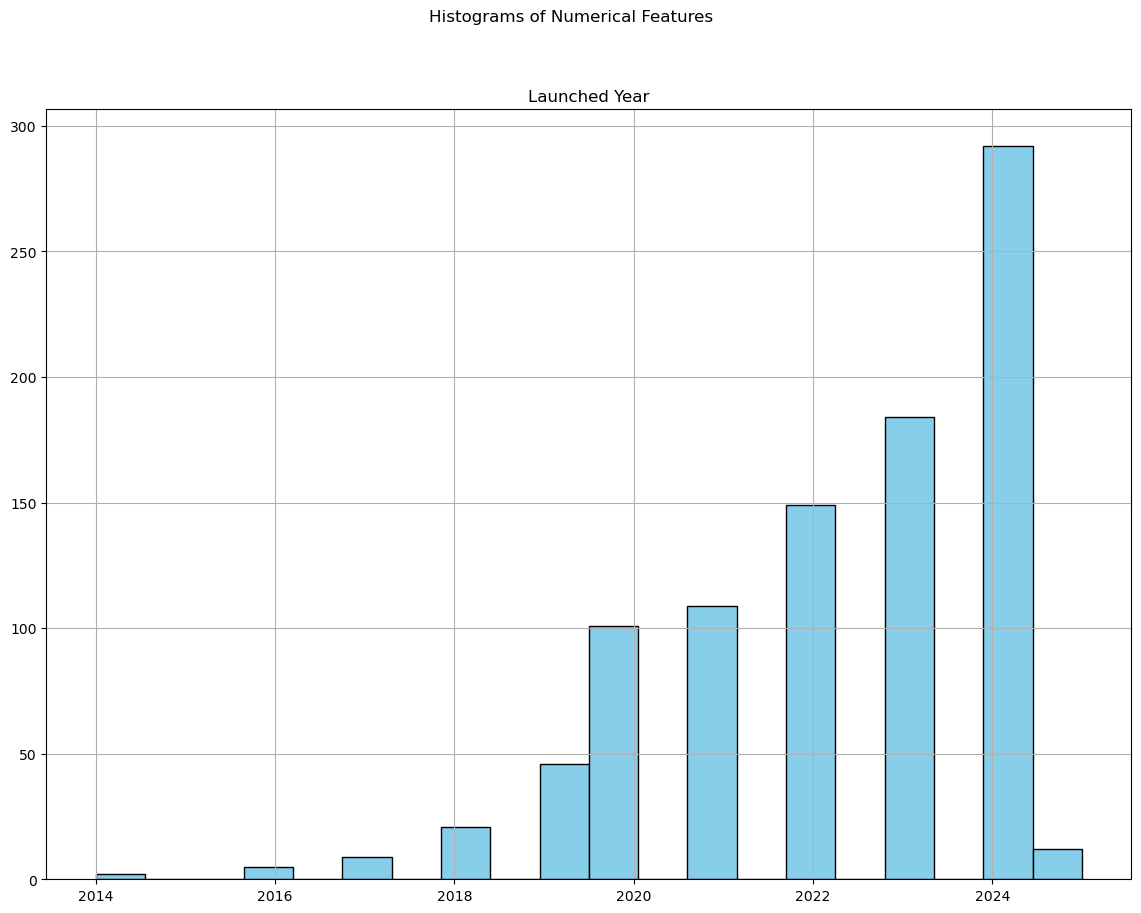

In [8]:
# Biểu đồ phân phối cho các thuộc tính số
numeric_features_eda = ['Mobile Weight', 'RAM', 'Front Camera', 'Back Camera', 'Battery Capacity', 'Screen Size', 'Launched Price (USA)', 'Launched Year']
df[numeric_features_eda].hist(bins=20, figsize=(14, 10), color='skyblue', edgecolor='black')
plt.suptitle("Histograms of Numerical Features")
plt.show()

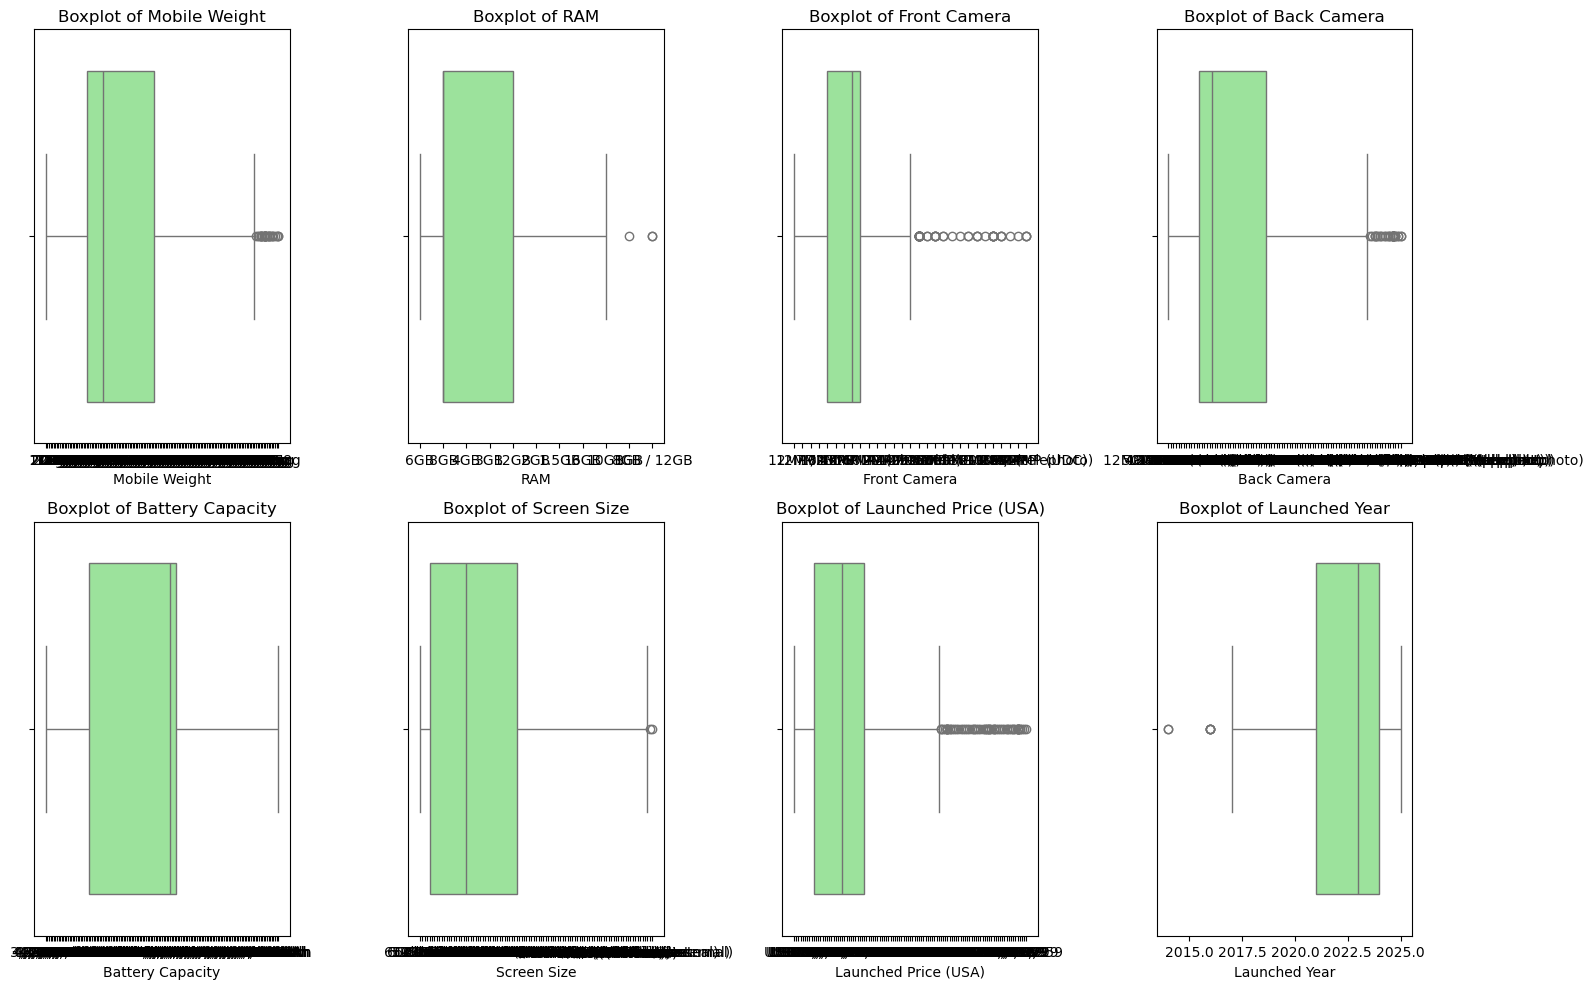

In [9]:
# Boxplots để kiểm tra các giá trị lạ (outlier) cho các thuộc tính số
plt.figure(figsize=(16, 10))
for i, feature in enumerate(numeric_features_eda):
    plt.subplot(2, 4, i+1)
    sns.boxplot(x=df[feature], color='lightgreen', showfliers=True)
    plt.title(f"Boxplot of {feature}", fontsize=12)
plt.tight_layout()
plt.show()

In [10]:
# Định nghĩa các cột có chứa đơn vị và giá trị cần loại bỏ
unit_columns = {
    'Mobile Weight': None,
    'RAM': None,
    'Front Camera': None,
    'Back Camera': None,
    'Battery Capacity': None,
    'Screen Size': None,
    'Launched Price (USA)': None,
    'Launched Price (Pakistan)': None,
    'Launched Price (India)': None,
    'Launched Price (China)': None,
    'Launched Price (Dubai)': None
}
for col in unit_columns.keys():
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace("[^0-9.]", "", regex=True)
        df[col] = pd.to_numeric(df[col], errors='coerce')
# Kiểm tra kết quả chuyển đổi cho 'Launched Price (USA)'
print("Sample of 'Launched Price (USA)' after conversion:")
print(df['Launched Price (USA)'].head(10))

Sample of 'Launched Price (USA)' after conversion:
0     799.0
1     849.0
2     899.0
3     899.0
4     949.0
5     999.0
6     999.0
7    1049.0
8    1099.0
9    1099.0
Name: Launched Price (USA), dtype: float64


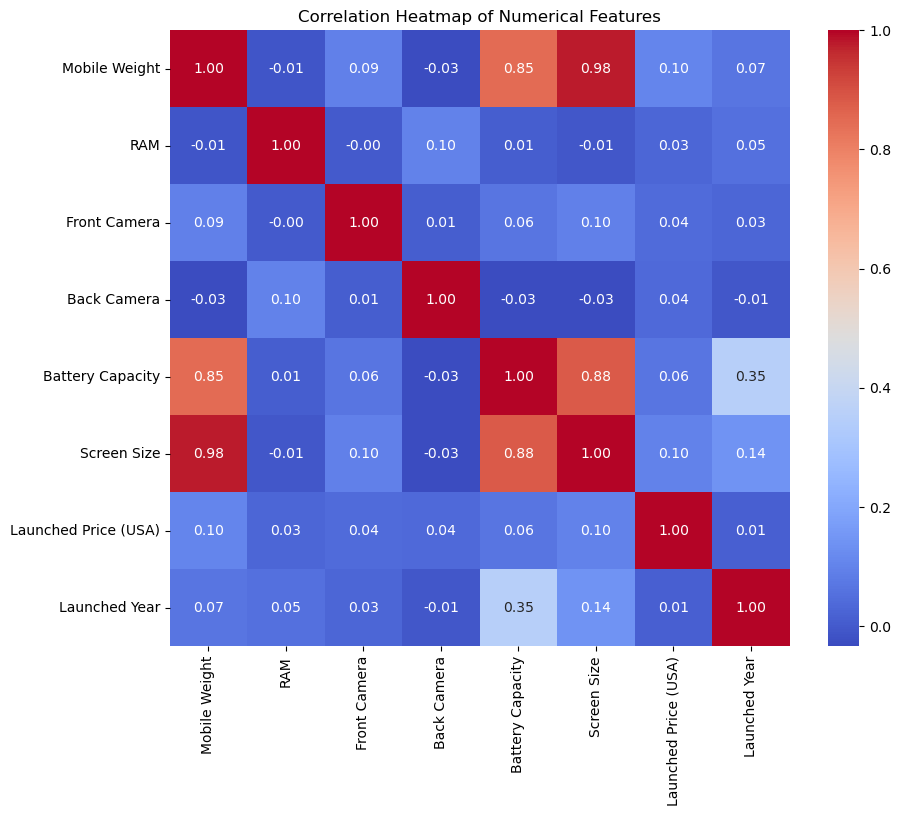

In [11]:
# Biểu đồ heatmap tương quan giữa các thuộc tính số (Correlation Heatmap)
plt.figure(figsize=(10, 8))
corr = df[numeric_features_eda].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

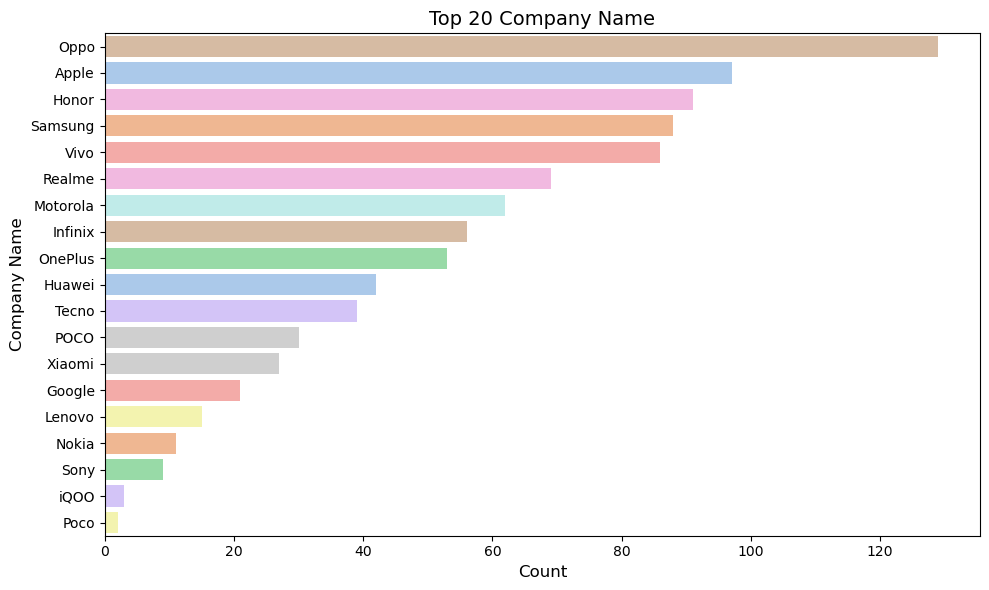

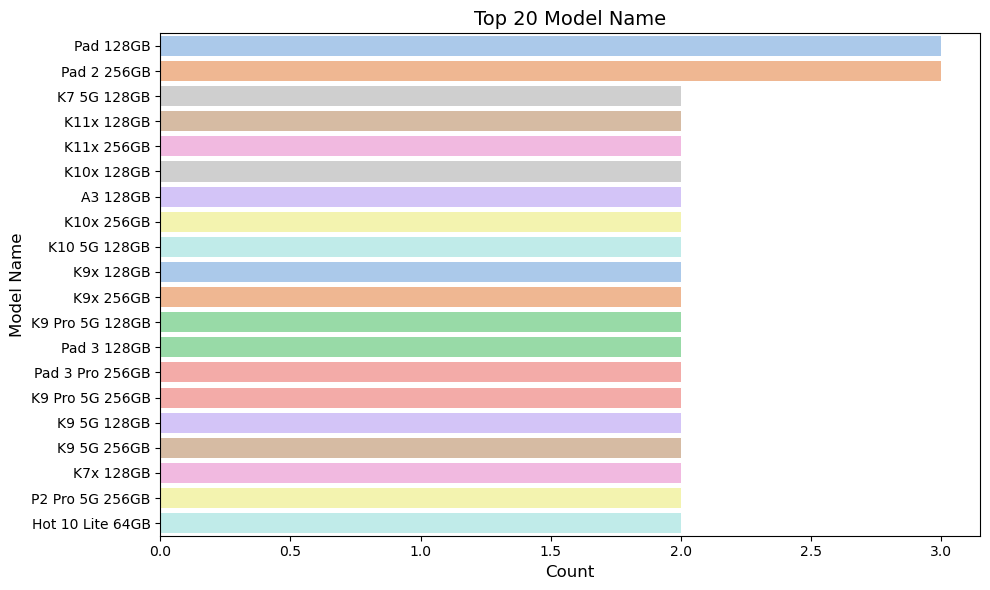

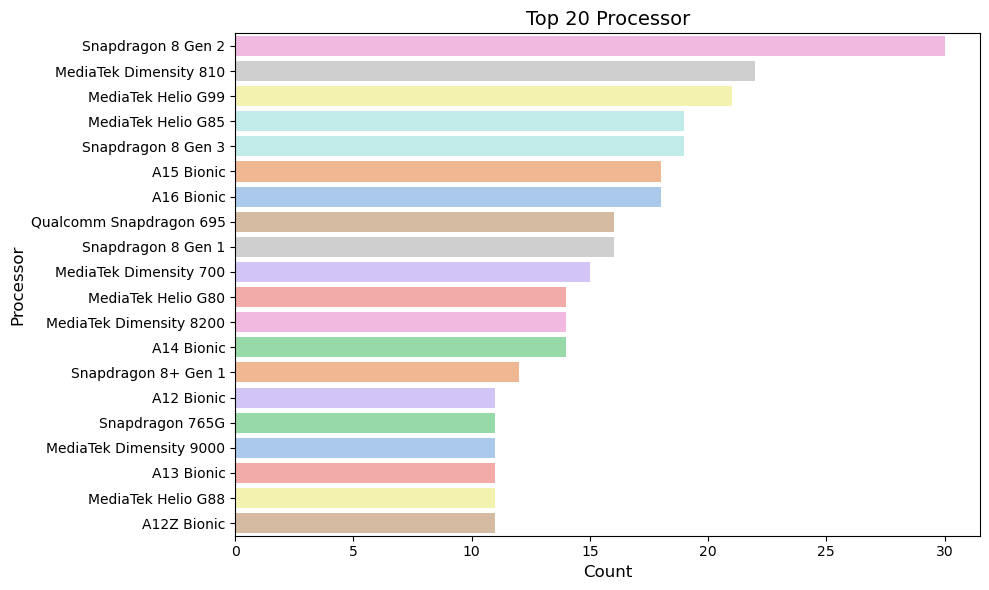

In [12]:
# Biểu đồ phân phối cho các thuộc tính danh mục (Company Name, Model Name, Processor)
categorical_features = ['Company Name', 'Model Name', 'Processor']
top_n = 20
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    top_values = df[feature].value_counts().nlargest(top_n).index
    df_top = df[df[feature].isin(top_values)]
    sns.countplot(        # Tránh cảnh báo không chỉ định biến hue từ thư viện Seaborn
        y=feature,
        data=df_top,
        order=top_values,
        hue=feature,
        palette="pastel",
        dodge=False,
        legend=False
    )
    plt.title(f"Top {top_n} {feature}", fontsize=14)
    plt.ylabel(feature, fontsize=12)
    plt.xlabel("Count", fontsize=12)
    plt.tight_layout()
    plt.show()

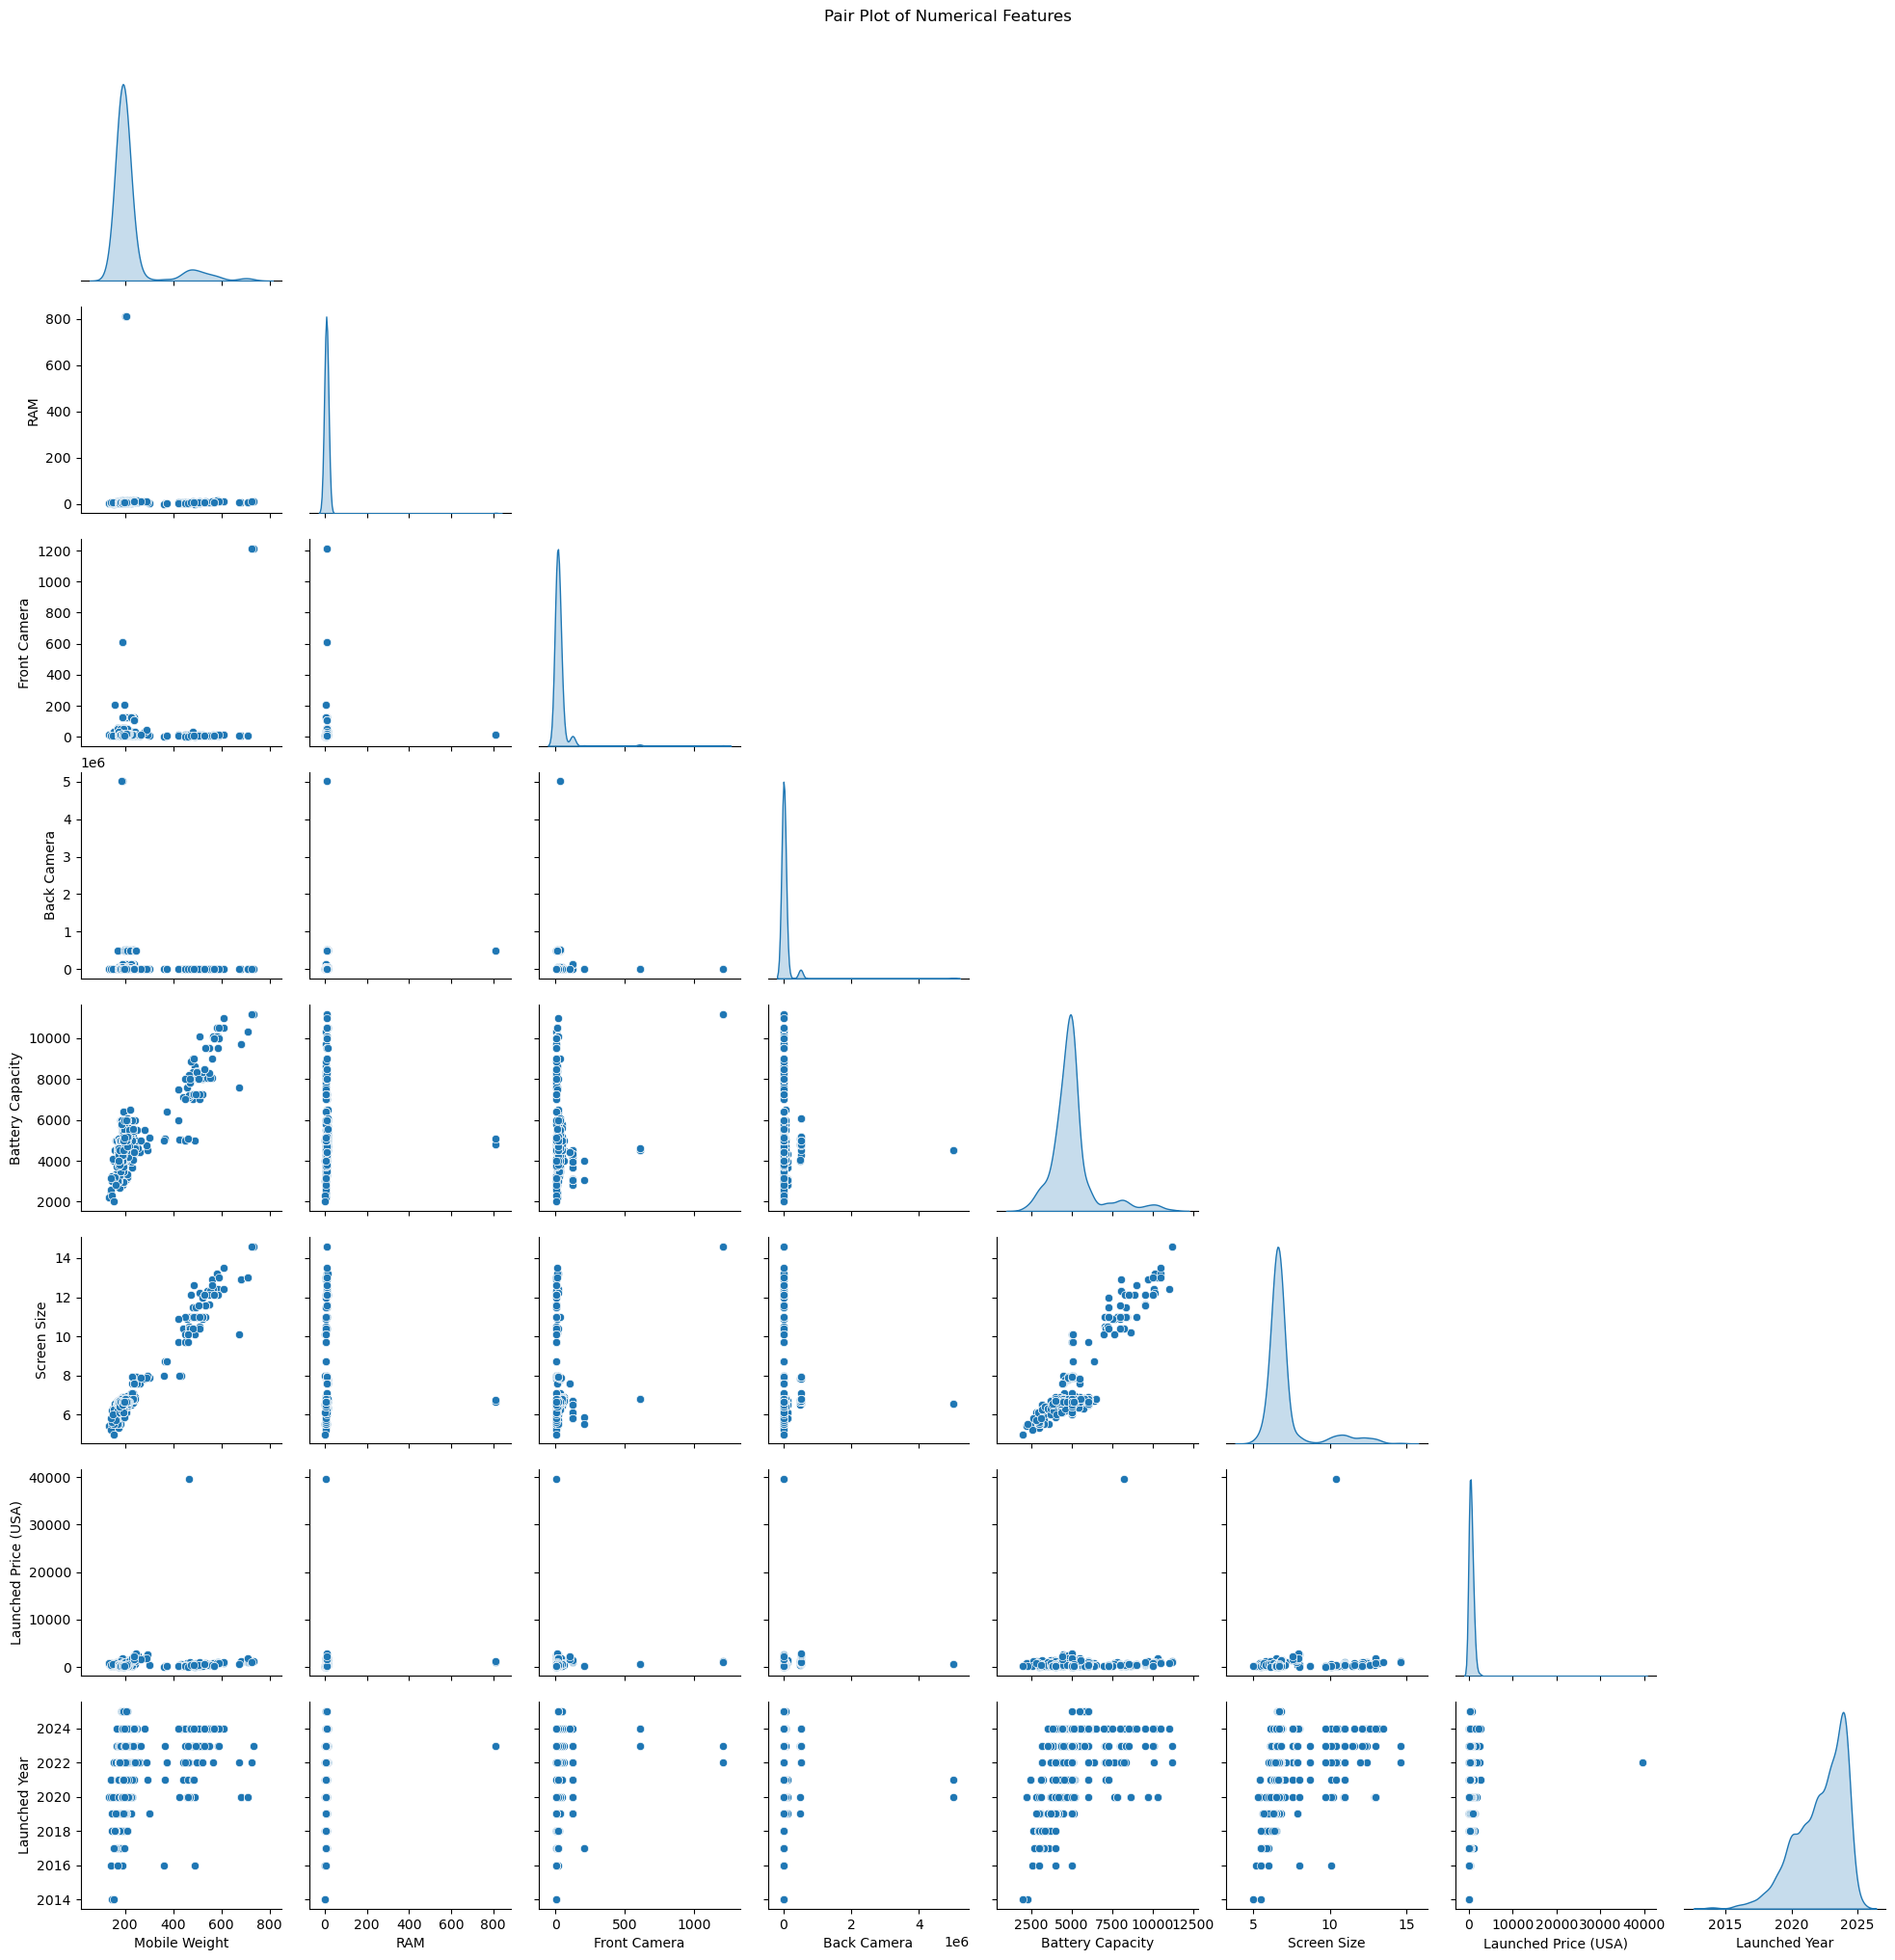

In [13]:
# Pair Plot cho các thuộc tính số (tạo sự liên kết giữa các biến)
sns.pairplot(df[numeric_features_eda], diag_kind='kde', corner=True)
plt.suptitle("Pair Plot of Numerical Features", y=1.02)
plt.show()

# Tiền xử lý dữ liệu và huấn luyện mô hình

In [14]:
# Loại bỏ các hàng có giá trị NaN trong các cột giá (cho tất cả các thị trường)
target_columns = ['Launched Price (USA)', 'Launched Price (Pakistan)', 'Launched Price (India)', 'Launched Price (China)', 'Launched Price (Dubai)']
df.dropna(subset=target_columns, inplace=True)
# Impute giá trị thiếu cho các cột mục tiêu
for col in target_columns:
    median_value = df[col].median()
    if np.isnan(median_value):
        print(f"Warning: {col} has all NaN values! Filling with 0.")
        df[col] = df[col].fillna(0)
    else:
        df[col] = df[col].fillna(median_value)
# In kích thước sau imputation
print("Shape of dataframe after imputing target columns:", df.shape)

Shape of dataframe after imputing target columns: (929, 15)


In [15]:
# Đặt các cột giá làm biến mục tiêu và loại bỏ các cột giá không cần thiết khỏi features
y = df[target_columns]
X = df.drop(target_columns, axis=1)

In [16]:
# Định nghĩa danh sách các thuộc tính số và danh mục
numeric_features_model = ['Mobile Weight', 'RAM', 'Front Camera', 'Back Camera', 'Battery Capacity', 'Screen Size', 'Launched Year']
categorical_features_model = ['Company Name', 'Model Name', 'Processor']

In [17]:
# Xây dựng pipeline tiền xử lý cho dữ liệu số: xử lý giá trị thiếu và chuẩn hóa
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Điền giá trị thiếu bằng trung vị
    ('scaler', StandardScaler())                     # Chuẩn hóa dữ liệu
])

In [18]:
# Xây dựng pipeline tiền xử lý cho dữ liệu danh mục: xử lý giá trị thiếu và one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Điền giá trị thiếu bằng 'missing'
    ('onehot', OneHotEncoder(handle_unknown='ignore'))                     # Chuyển đổi dữ liệu thành dạng số
])

In [19]:
# Kết hợp các bước tiền xử lý cho dữ liệu số và dữ liệu danh mục
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_model),
        ('cat', categorical_transformer, categorical_features_model)
    ]
)

In [20]:
# Chọn mô hình Random Forest Regressor (hỗ trợ multi-target regression)
model = RandomForestRegressor(random_state=42)

In [21]:
# Tạo pipeline kết hợp tiền xử lý và mô hình
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', model)])

In [22]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# In kích thước tập huấn luyện và tập kiểm tra của X
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (743, 10)
Test set shape: (186, 10)


In [23]:
# Huấn luyện mô hình
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Mobile Weight', 'RAM',
                                                   'Front Camera',
                                                   'Back Camera',
                                                   'Battery Capacity',
                                                   'Screen Size',
                                                   'Launched Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Company Name', 'Model Name',
                                                   'Processor'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [24]:
# Dự đoán và đánh giá
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 236473983.76302347
R-squared: 0.7227051489008546


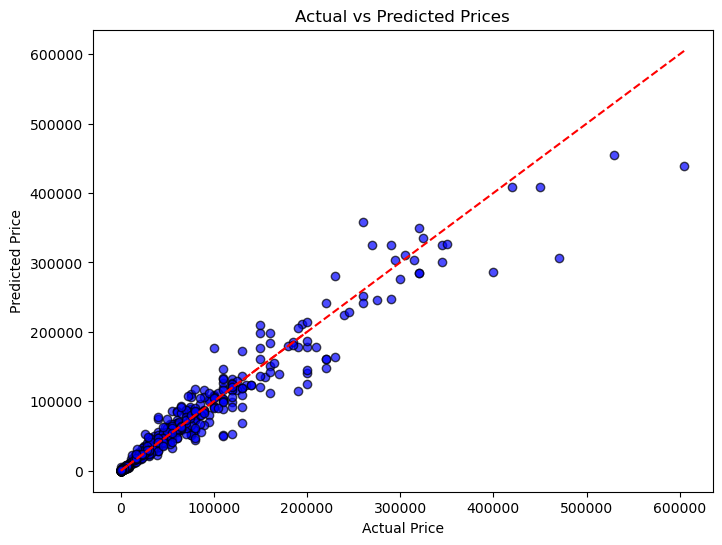

In [25]:
# Biểu đồ so sánh giá thực và giá dự đoán
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolor='k', alpha=0.7)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

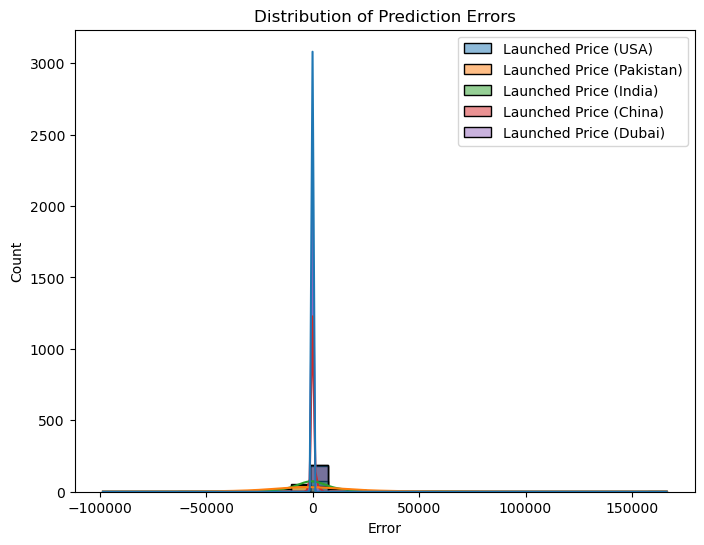

In [26]:
# Biểu đồ phân phối của sai số dự đoán
errors = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(errors, bins=30, kde=True, color='purple')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error")
plt.show()

In [27]:
# Tích hợp chức năng nhập thủ công dữ liệu và dự đoán
def manual_input_prediction():
    print("Enter phone specifications:")
    mobile_weight = input("Mobile Weight(g): ")
    ram = input("RAM(GB): ")
    front_camera = input("Front Camera(MP): ")
    back_camera = input("Back Camera(MP): ")
    battery_capacity = input("Battery Capacity(mAh): ")
    screen_size = input("Screen Size(inches): ")
    launched_year = input("Launched Year: ")
    company_name = input("Company Name: ")
    model_name = input("Model Name: ")
    processor = input("Processor: ")
    # Tạo DataFrame từ dữ liệu nhập vào
    data = {
        'Mobile Weight': [float(mobile_weight)],
        'RAM': [float(ram)],
        'Front Camera': [float(front_camera)],
        'Back Camera': [float(back_camera)],
        'Battery Capacity': [float(battery_capacity)],
        'Screen Size': [float(screen_size)],
        'Launched Year': [int(launched_year)],
        'Company Name': [company_name],
        'Model Name': [model_name],
        'Processor': [processor]
    }
    input_df = pd.DataFrame(data) 
    # Dự đoán giá khởi chạy cho các quốc gia
    predictions = pipeline.predict(input_df)
    target_labels = ['Launched Price (USA)', 'Launched Price (Pakistan)', 'Launched Price (India)', 'Launched Price (China)', 'Launched Price (Dubai)']
    print("\nDự đoán giá khởi chạy:")
    for label, price in zip(target_labels, predictions[0]):
        print(f"{label}: {price:.2f}")
# Gọi hàm nhập thủ công và dự đoán
manual_input_prediction()

Enter phone specifications:


Mobile Weight(g):  203
RAM(GB):  6
Front Camera(MP):  12
Back Camera(MP):  48
Battery Capacity(mAh):  4200
Screen Size(inches):  6.7
Launched Year:  2024
Company Name:  Apple
Model Name:  iPhone 16 128GB
Processor:  A17 Bionic



Dự đoán giá khởi chạy:
Launched Price (USA): 896.50
Launched Price (Pakistan): 245399.00
Launched Price (India): 89248.01
Launched Price (China): 6196.00
Launched Price (Dubai): 3175.00
